# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Feature engineering
4. Modelling

---

## 1. Import packages

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)


---
## 2. Load data

In [31]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [32]:
df.head(3)

Unnamed: 0                                id  \
0           0  764c75f661154dac3a6c254cd082ea7d   
1           1  01495c955be7ec5e7f3203406785aae0   
2           2  d5e512dbc8118a830a7b8c7f61d89992   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
1  foosdfpfkusacimwkcsosbicdxkicaua     29552             0             1260   
2  usilxuppasemubllopkaafesmlibmsdf     10831             0             3112   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
1 2010-04-21 2016-04-21      2010-04-21   2015-04-22  ...   
2 2011-07-11 2016-07-11      2011-07-11   2015-07-12  ...   

   mean_6m_price_off_peak_var  mean_6m_price_peak_var  \
0                3.569731e-06            9.450150e-08   
1                1.110032e-05            2.896760e-06   
2                3.988682e-07            2.253388e-06   

   mean_6m_price_mid_peak_var  mean_6m_price_off_peak_fix  \
0                0.000000e+00                    0.000000   
1                4.860000e-10                    0.000000   
2                0.000000e+00                    0.005268   

   mean_6m_price_peak_fix  mean_6m_price_mid_peak_fix  mean_6m_price_off_peak  \
0                     0.0                         0.0                0.000004   
1                     0.0                         0.0                0.000011   
2                     0.0                         0.0                0.005268   

  mean_6m_price_peak  mean_6m_price_mid_peak  churn  
0       9.450150e-08            0.000000e+00      0  
1       2.896760e-06            4.860000e-10      0  
2       2.253388e-06            0.000000e+00      0  

[3 rows x 45 columns]

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [33]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [34]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                        -0.010018   
4  00114d74e963e47177db89bc70108537                        -0.003994   

   offpeak_diff_dec_january_power  
0                        0.162916  
1                        0.177779  
2                        1.500000  
3                        0.162916  
4                       -0.000001

In [35]:
df = pd.merge(df, diff, on='id')
df.head()


Unnamed: 0                                id  \
0           0  764c75f661154dac3a6c254cd082ea7d   
1           1  01495c955be7ec5e7f3203406785aae0   
2           2  d5e512dbc8118a830a7b8c7f61d89992   
3           3  21860c2ff2d5df75503b230ce629c253   
4           4  e4773b60d2e68aac94795782abfc006b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
1  foosdfpfkusacimwkcsosbicdxkicaua     29552             0             1260   
2  usilxuppasemubllopkaafesmlibmsdf     10831             0             3112   
3  foosdfpfkusacimwkcsosbicdxkicaua      7726             0                0   
4  lmkebamcaaclubfxadlmueccxoimlema     47019             0             3161   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
1 2010-04-21 2016-04-21      2010-04-21   2015-04-22  ...   
2 2011-07-11 2016-07-11      2011-07-11   2015-07-12  ...   
3 2013-01-22 2017-01-22      2015-11-18   2016-01-24  ...   
4 2012-04-20 2016-04-20      2012-04-20   2015-04-21  ...   

   mean_6m_price_mid_peak_var  mean_6m_price_off_peak_fix  \
0                0.000000e+00                    0.000000   
1                4.860000e-10                    0.000000   
2                0.000000e+00                    0.005268   
3                0.000000e+00                    0.009482   
4                0.000000e+00                    0.000000   

   mean_6m_price_peak_fix  mean_6m_price_mid_peak_fix  mean_6m_price_off_peak  \
0                     0.0                         0.0                0.000004   
1                     0.0                         0.0                0.000011   
2                     0.0                         0.0                0.005268   
3                     0.0                         0.0                0.009490   
4                     0.0                         0.0                0.000003   

   mean_6m_price_peak  mean_6m_price_mid_peak churn  \
0        9.450150e-08            0.000000e+00     0   
1        2.896760e-06            4.860000e-10     0   
2        2.253388e-06            0.000000e+00     0   
3        3.515100e-06            0.000000e+00     0   
4        0.000000e+00            0.000000e+00     0   

   offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  
0                        -0.004670                        0.177779  
1                        -0.007801                        0.162916  
2                        -0.001547                        0.177779  
3                        -0.008152                        0.177779  
4                        -0.003423                        0.177779  

[5 rows x 47 columns]


# AVGERAGE PRICE CHANGES ACROSS PERIODS


---
Calculating the average price changes across individual periods, instead of the entire year


---







In [36]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var':'mean',
    'price_peak_var':'mean',
    'price_mid_peak_var':'mean',
    'price_off_peak_fix':'mean',
    'price_peak_fix':'mean',
    'price_mid_peak_fix':'mean'
}).reset_index()

In [37]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']


In [38]:
columns = [
    'id',
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff',
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff',
    'peak_mid_peak_fix_mean_diff',
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

Unnamed: 0                                id  \
0           0  764c75f661154dac3a6c254cd082ea7d   
1           1  01495c955be7ec5e7f3203406785aae0   
2           2  d5e512dbc8118a830a7b8c7f61d89992   
3           3  21860c2ff2d5df75503b230ce629c253   
4           4  e4773b60d2e68aac94795782abfc006b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
1  foosdfpfkusacimwkcsosbicdxkicaua     29552             0             1260   
2  usilxuppasemubllopkaafesmlibmsdf     10831             0             3112   
3  foosdfpfkusacimwkcsosbicdxkicaua      7726             0                0   
4  lmkebamcaaclubfxadlmueccxoimlema     47019             0             3161   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
1 2010-04-21 2016-04-21      2010-04-21   2015-04-22  ...   
2 2011-07-11 2016-07-11      2011-07-11   2015-07-12  ...   
3 2013-01-22 2017-01-22      2015-11-18   2016-01-24  ...   
4 2012-04-20 2016-04-20      2012-04-20   2015-04-21  ...   

   mean_6m_price_mid_peak  churn  offpeak_diff_dec_january_energy  \
0            0.000000e+00      0                        -0.004670   
1            4.860000e-10      0                        -0.007801   
2            0.000000e+00      0                        -0.001547   
3            0.000000e+00      0                        -0.008152   
4            0.000000e+00      0                        -0.003423   

   offpeak_diff_dec_january_power  off_peak_peak_var_mean_diff  \
0                        0.177779                     0.082090   
1                        0.162916                     0.020314   
2                        0.177779                     0.081795   
3                        0.177779                     0.081538   
4                        0.177779                     0.149044   

   peak_mid_peak_var_mean_diff  off_peak_mid_peak_var_mean_diff  \
0                     0.088421                         0.170512   
1                     0.028965                         0.049279   
2                     0.085745                         0.167540   
3                     0.087640                         0.169177   
4                     0.000000                         0.149044   

  off_peak_peak_fix_mean_diff  peak_mid_peak_fix_mean_diff  \
0                   44.385450                     0.000000   
1                   16.269833                     8.134914   
2                   44.341005                     0.000000   
3                   44.311375                     0.000000   
4                   44.385450                     0.000000   

   off_peak_mid_peak_fix_mean_diff  
0                        44.385450  
1                        24.404747  
2                        44.341005  
3                        44.311375  
4                        44.385450  

[5 rows x 53 columns]

This feature may be useful because it adds more granularity to the existing feature that my colleague found to be useful. Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (off_peak, peak, mid_peak). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.



#Max price changes across periods and months

---


Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

---



---







In [39]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [40]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']


In [41]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [42]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()


Unnamed: 0                                id  \
0           0  764c75f661154dac3a6c254cd082ea7d   
1           1  01495c955be7ec5e7f3203406785aae0   
2           2  d5e512dbc8118a830a7b8c7f61d89992   
3           3  21860c2ff2d5df75503b230ce629c253   
4           4  e4773b60d2e68aac94795782abfc006b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
1  foosdfpfkusacimwkcsosbicdxkicaua     29552             0             1260   
2  usilxuppasemubllopkaafesmlibmsdf     10831             0             3112   
3  foosdfpfkusacimwkcsosbicdxkicaua      7726             0                0   
4  lmkebamcaaclubfxadlmueccxoimlema     47019             0             3161   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
1 2010-04-21 2016-04-21      2010-04-21   2015-04-22  ...   
2 2011-07-11 2016-07-11      2011-07-11   2015-07-12  ...   
3 2013-01-22 2017-01-22      2015-11-18   2016-01-24  ...   
4 2012-04-20 2016-04-20      2012-04-20   2015-04-21  ...   

   off_peak_mid_peak_var_mean_diff  off_peak_peak_fix_mean_diff  \
0                         0.170512                    44.385450   
1                         0.049279                    16.269833   
2                         0.167540                    44.341005   
3                         0.169177                    44.311375   
4                         0.149044                    44.385450   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                     0.000000                        44.385450   
1                     8.134914                        24.404747   
2                     0.000000                        44.341005   
3                     0.000000                        44.311375   
4                     0.000000                        44.385450   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                            0.084587                            0.089162   
1                            0.022581                            0.031859   
2                            0.083972                            0.087890   
3                            0.084587                            0.088815   
4                            0.151250                            0.000000   

   off_peak_mid_peak_var_max_monthly_diff off_peak_peak_fix_max_monthly_diff  \
0                                0.172468                          44.444710   
1                                0.054440                          16.291555   
2                                0.168185                          44.444710   
3                                0.172468                          44.444710   
4                                0.151250                          44.444710   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                            0.000000                                44.44471  
1                            8.145775                                24.43733  
2                            0.000000                                44.44471  
3                            0.000000                                44.44471  
4                            0.000000                                44.44471  

[5 rows x 59 columns]



---
Creating a feature that calculates the maximum price change between months and time periods. This feature would be relevant to PowerCo clients, as sudden and large price increases are likely to be a significant factor in customer churn.



---



#BONUS Feature Engineering

---


This section covers extra feature engineering that you may have thought of, as well as different ways you can transform your data to account for some of its statistical properties that we saw before, such as skewness.

---




## Tenure
How long a company has been a client of PowerCo.

In [43]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)


In [44]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)


churn
tenure          
13      0.166667
4       0.134276
3       0.133909
2       0.122449
8       0.086957
5       0.082502
7       0.081203
6       0.079848
12      0.073171
11      0.037037
9       0.000000
10      0.000000

We can see that companies who have only been a client for 4 or less months are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer.

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

#Transforming dates into months
* months_activ = Number of months active
until reference date (Jan 2016)
* months_to_end = Number of months of the contract left until reference date (Jan 2016)
* months_modif_prod = Number of months since last modification until reference date (Jan 2016)
* months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [19]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months


In [20]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')


Datetime objects are not useful for predictive models, so we created new features based on the datetimes that may be more predictive.

For example, a customer who has been active with PowerCo for a longer period of time may be more loyal to the brand and less likely to churn, while a newer customer may be more volatile. Therefore, we added the months_activ feature.

Additionally, consider a customer who is nearing the end of their contract with PowerCo. They may be looking for better deals elsewhere, or they may be planning to renew their contract. On the other hand, a new customer may have a grace period during which they can cancel without penalty, while a customer in the middle of their contract may be subject to early termination fees. Therefore, we believe the months_to_end feature may reveal patterns and behaviors related to churn timing.

We also believe that customers who have recently updated their contracts are more likely to be satisfied with PowerCo's services, as this indicates that they have received a level of customer service that prompted them to make changes. Therefore, we believe the months_modif_prod feature will be useful for understanding how engaged customers are with PowerCo.

Finally, we believe that the number of months since a customer last renewed their contract is another indicator of engagement and commitment. Therefore, we believe the months_renewal feature will be useful for predicting churn.

In [45]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()


Unnamed: 0                                id  \
0           0  764c75f661154dac3a6c254cd082ea7d   
1           1  01495c955be7ec5e7f3203406785aae0   
2           2  d5e512dbc8118a830a7b8c7f61d89992   
3           3  21860c2ff2d5df75503b230ce629c253   
4           4  e4773b60d2e68aac94795782abfc006b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
1  foosdfpfkusacimwkcsosbicdxkicaua     29552             0             1260   
2  usilxuppasemubllopkaafesmlibmsdf     10831             0             3112   
3  foosdfpfkusacimwkcsosbicdxkicaua      7726             0                0   
4  lmkebamcaaclubfxadlmueccxoimlema     47019             0             3161   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0              47.96                   0                       0.0   
1             864.73                 751                       0.0   
2            1204.58                3112                       0.0   
3             914.10                   0                       0.0   
4            1687.29                1080                       0.0   

   forecast_meter_rent_12m  ...  off_peak_peak_fix_mean_diff  \
0                    38.72  ...                    44.385450   
1                   144.49  ...                    16.269833   
2                    20.94  ...                    44.341005   
3                    74.66  ...                    44.311375   
4                    16.08  ...                    44.385450   

   peak_mid_peak_fix_mean_diff  off_peak_mid_peak_fix_mean_diff  \
0                     0.000000                        44.385450   
1                     8.134914                        24.404747   
2                     0.000000                        44.341005   
3                     0.000000                        44.311375   
4                     0.000000                        44.385450   

  off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                           0.084587                            0.089162   
1                           0.022581                            0.031859   
2                           0.083972                            0.087890   
3                           0.084587                            0.088815   
4                           0.151250                            0.000000   

   off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                                0.172468                           44.444710   
1                                0.054440                           16.291555   
2                                0.168185                           44.444710   
3                                0.172468                           44.444710   
4                                0.151250                           44.444710   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  \
0                            0.000000                                44.44471   
1                            8.145775                                24.43733   
2                            0.000000                                44.44471   
3                            0.000000                                44.44471   
4                            0.000000                                44.44471   

   tenure  
0       6  
1       6  
2       5  
3       4  
4       4  

[5 rows x 56 columns]

#Transforming Boolean data
## has_gas
We simply want to transform this column from being categorical to being a binary flag



In [46]:
df['has_gas'] = df['has_gas'].replace(['t','f'],[1,0])
df.groupby(['has_gas']).agg({'churn':'mean'})

churn
has_gas          
0        0.105765
1        0.078801

The customers who do not buy gas are almost 2%,these are more likely to churn than customers who also buy gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand.Hence, this is a useful feature

# Transforming categorical data


In [47]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    2405
MISSING                             1091
lmkebamcaaclubfxadlmueccxoimlema     635
usilxuppasemubllopkaafesmlibmsdf     509
ewpakwlliwisiwduibdlfmalxowmwpci     347
sddiedcslfslkckwlfkdpoeeailfpeds       6
epumfxlbckeskwekxbiuasklxalciiuu       1
fixdbufsefwooaasfcxdxadsiekoceaa       1
Name: channel_sales, dtype: int64

In [48]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  764c75f661154dac3a6c254cd082ea7d       544             0   
1           1  01495c955be7ec5e7f3203406785aae0     29552             0   
2           2  d5e512dbc8118a830a7b8c7f61d89992     10831             0   
3           3  21860c2ff2d5df75503b230ce629c253      7726             0   
4           4  e4773b60d2e68aac94795782abfc006b     47019             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0              47.96                   0   
1             1260             864.73                 751   
2             3112            1204.58                3112   
3                0             914.10                   0   
4             3161            1687.29                1080   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                    38.72   
1                       0.0                   144.49   
2                       0.0                    20.94   
3                       0.0                    74.66   
4                       0.0                    16.08   

   forecast_price_energy_off_peak  ...  \
0                        0.165794  ...   
1                        0.115174  ...   
2                        0.164637  ...   
3                        0.162327  ...   
4                        0.144902  ...   

   off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                                0.172468                           44.444710   
1                                0.054440                           16.291555   
2                                0.168185                           44.444710   
3                                0.172468                           44.444710   
4                                0.151250                           44.444710   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  \
0                            0.000000                                44.44471   
1                            8.145775                                24.43733   
2                            0.000000                                44.44471   
3                            0.000000                                44.44471   
4                            0.000000                                44.44471   

   tenure  channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0       6                0                                         0   
1       6                0                                         0   
2       5                0                                         0   
3       4                0                                         0   
4       4                0                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         1   
2                                         0   
3                                         1   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         1   

  channel_usilxuppasemubllopkaafesmlibmsdf  
0                                        0  
1                                        0  
2                                        1  
3                                        0  
4                                        0  

[5 rows x 60 columns]

In [49]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    2591
kamkkxfxxuwbdslkwifmmcsiusiuosws    1322
ldkssxwpmemidmecebumciepifcamkci    1057
MISSING                               24
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [50]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  764c75f661154dac3a6c254cd082ea7d       544             0   
1           1  01495c955be7ec5e7f3203406785aae0     29552             0   
2           2  d5e512dbc8118a830a7b8c7f61d89992     10831             0   
3           3  21860c2ff2d5df75503b230ce629c253      7726             0   
4           4  e4773b60d2e68aac94795782abfc006b     47019             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0              47.96                   0   
1             1260             864.73                 751   
2             3112            1204.58                3112   
3                0             914.10                   0   
4             3161            1687.29                1080   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                    38.72   
1                       0.0                   144.49   
2                       0.0                    20.94   
3                       0.0                    74.66   
4                       0.0                    16.08   

   forecast_price_energy_off_peak  ...  \
0                        0.165794  ...   
1                        0.115174  ...   
2                        0.164637  ...   
3                        0.162327  ...   
4                        0.144902  ...   

   off_peak_mid_peak_fix_max_monthly_diff  tenure  channel_MISSING  \
0                                44.44471       6                0   
1                                24.43733       6                0   
2                                44.44471       5                0   
3                                44.44471       4                0   
4                                44.44471       4                0   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         1   
2                                         0   
3                                         1   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         1   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           1   
1                                           0   
2                                           1   
3                                           0   
4                                           0   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           1   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           0  
1                                           1  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 62 columns]

## Transforming numerical data

In [51]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  4.995000e+03  4.995000e+03      4995.000000        4995.000000   
mean   1.663136e+05  2.669972e+04     16882.270671        1906.506232   
std    5.862028e+05  1.480008e+05     66630.959513        2368.808621   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674000e+03  0.000000e+00         0.000000         505.915000   
50%    1.473400e+04  0.000000e+00       786.000000        1139.530000   
75%    4.323850e+04  0.000000e+00      3557.000000        2517.615000   
max    6.207104e+06  2.055098e+06    771203.000000       61357.170000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count         4995.000000               4995.000000              4995.000000   
mean          1344.847247                  0.989189                63.030803   
std           2580.029093                  5.152489                64.260137   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.165000   
50%            320.000000                  0.000000                18.920000   
75%           1697.500000                  0.000000               131.010000   
max          63969.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                     4995.000000                 4995.000000   
mean                         0.136878                    0.050182   
std                          0.024057                    0.049158   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.083916   
75%                          0.145884                    0.098841   
max                          0.273963                    0.168092   

       forecast_price_pow_off_peak  
count                  4995.000000  
mean                     43.075634  
std                       4.298799  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

In [52]:
#Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)


In [53]:
df[skewed].describe()


cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  4995.000000   4995.000000      4995.000000        4995.000000   
mean      4.242982      0.771010         2.287093           2.972543   
std       0.884039      1.707728         1.771714           0.683770   
min       0.000000      0.000000         0.000000           0.000000   
25%       3.753966      0.000000         0.000000           2.704935   
50%       4.168350      0.000000         2.895975           3.057107   
75%       4.635880      0.000000         3.551206           3.401162   
max       6.792889      6.312833         5.887169           4.787872   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count         4995.000000               4995.000000              4995.000000   
mean             1.788330                  0.989189                 1.514454   
std              1.578582                  5.152489                 0.581579   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.234644   
50%              2.506505                  0.000000                 1.299289   
75%              3.230065                  0.000000                 2.120607   
max              4.805976                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                     4995.000000                 4995.000000   
mean                         0.136878                    0.050182   
std                          0.024057                    0.049158   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.083916   
75%                          0.145884                    0.098841   
max                          0.273963                    0.168092   

       forecast_price_pow_off_peak  
count                  4995.000000  
mean                     43.075634  
std                       4.298799  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

 Checking the distributions of some of these features too.

<ipython-input-54-f63759cfd0e3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
<ipython-input-54-f63759cfd0e3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
<ipython-input-54-f63759cfd0e3>:5: U

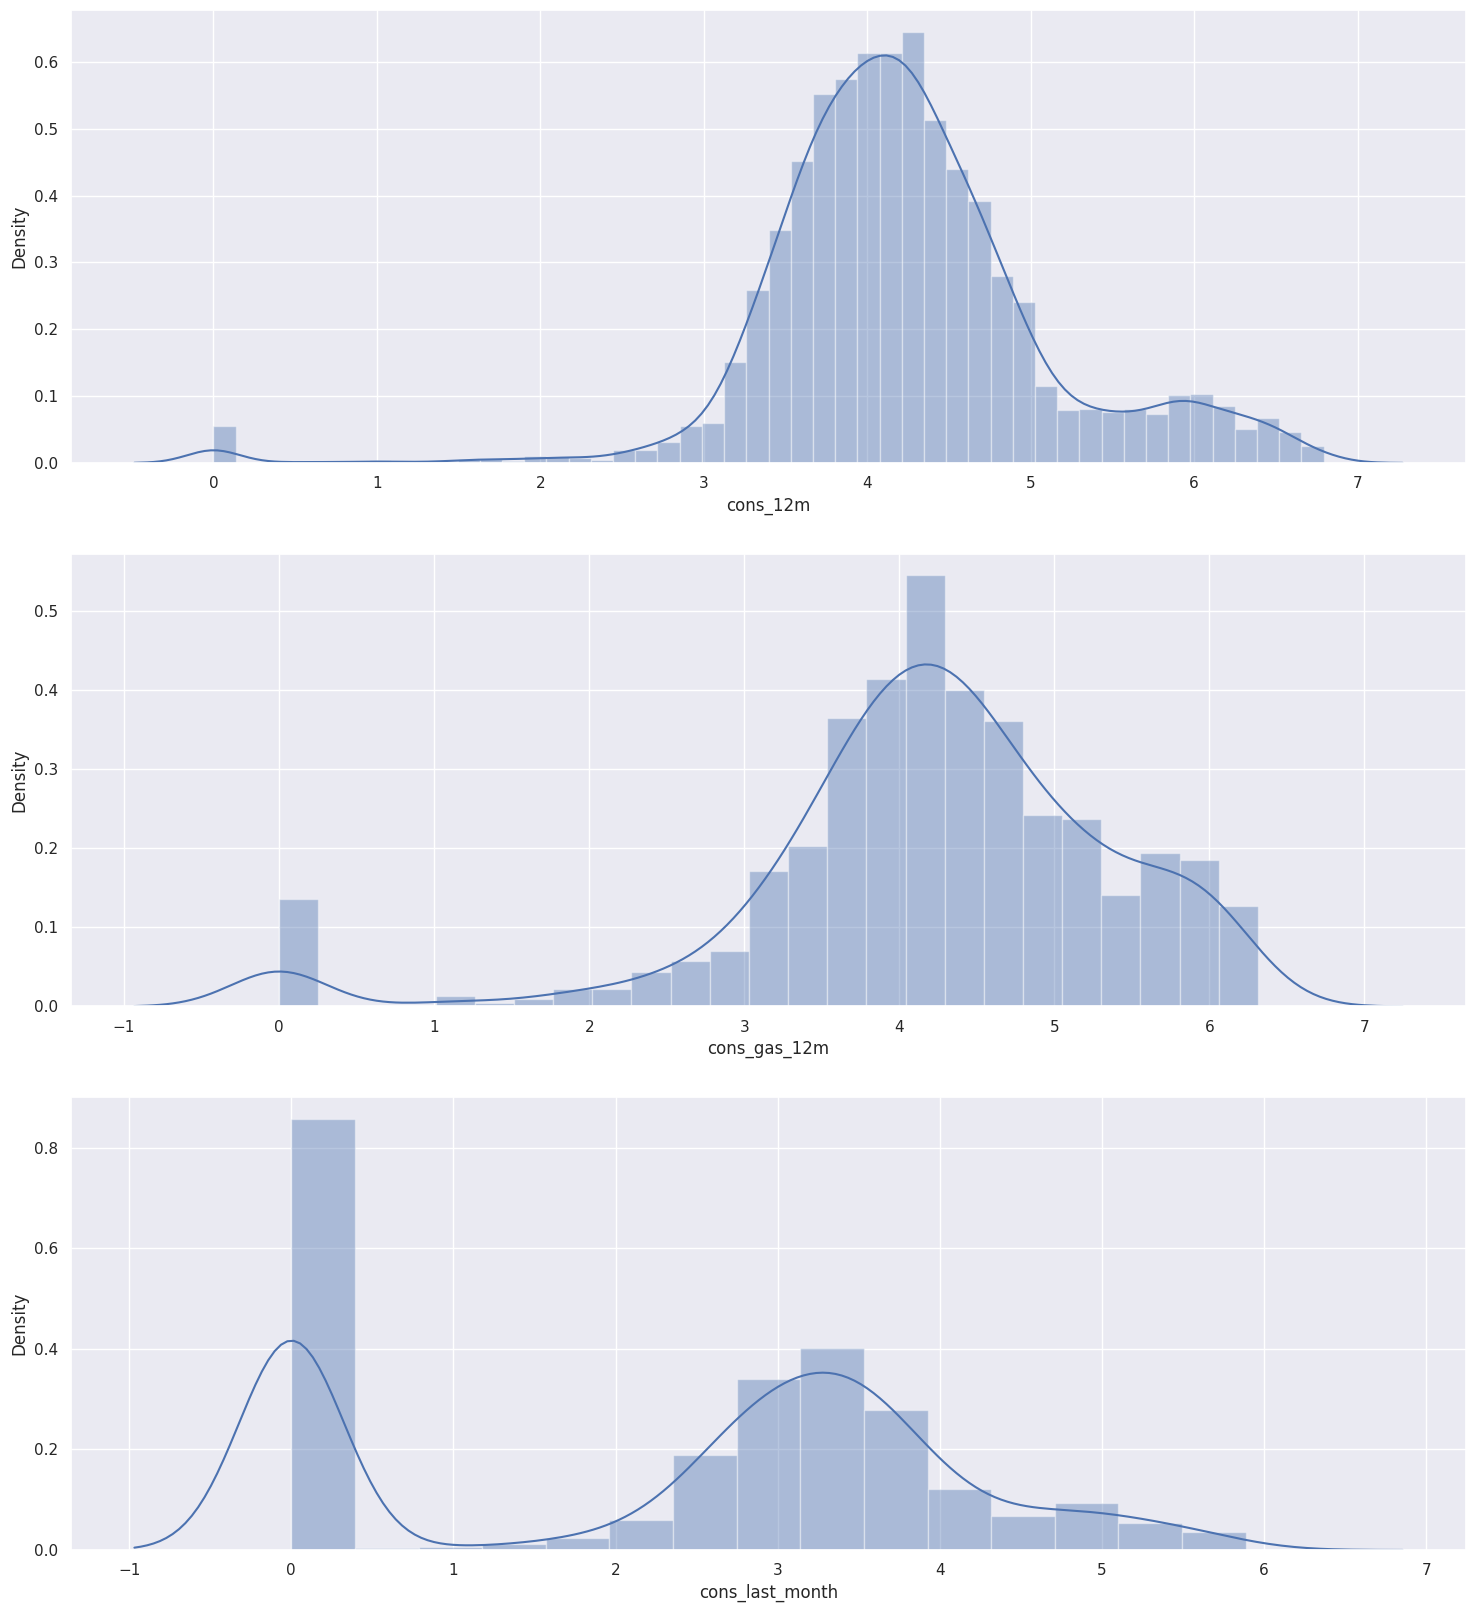

In [54]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

# Corelations
This is important because it reveals the linear relationships between features. We want features to correlate with churn, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information. One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption.

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [55]:
correlation = df.corr()


<ipython-input-55-bbce1ddb6927>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


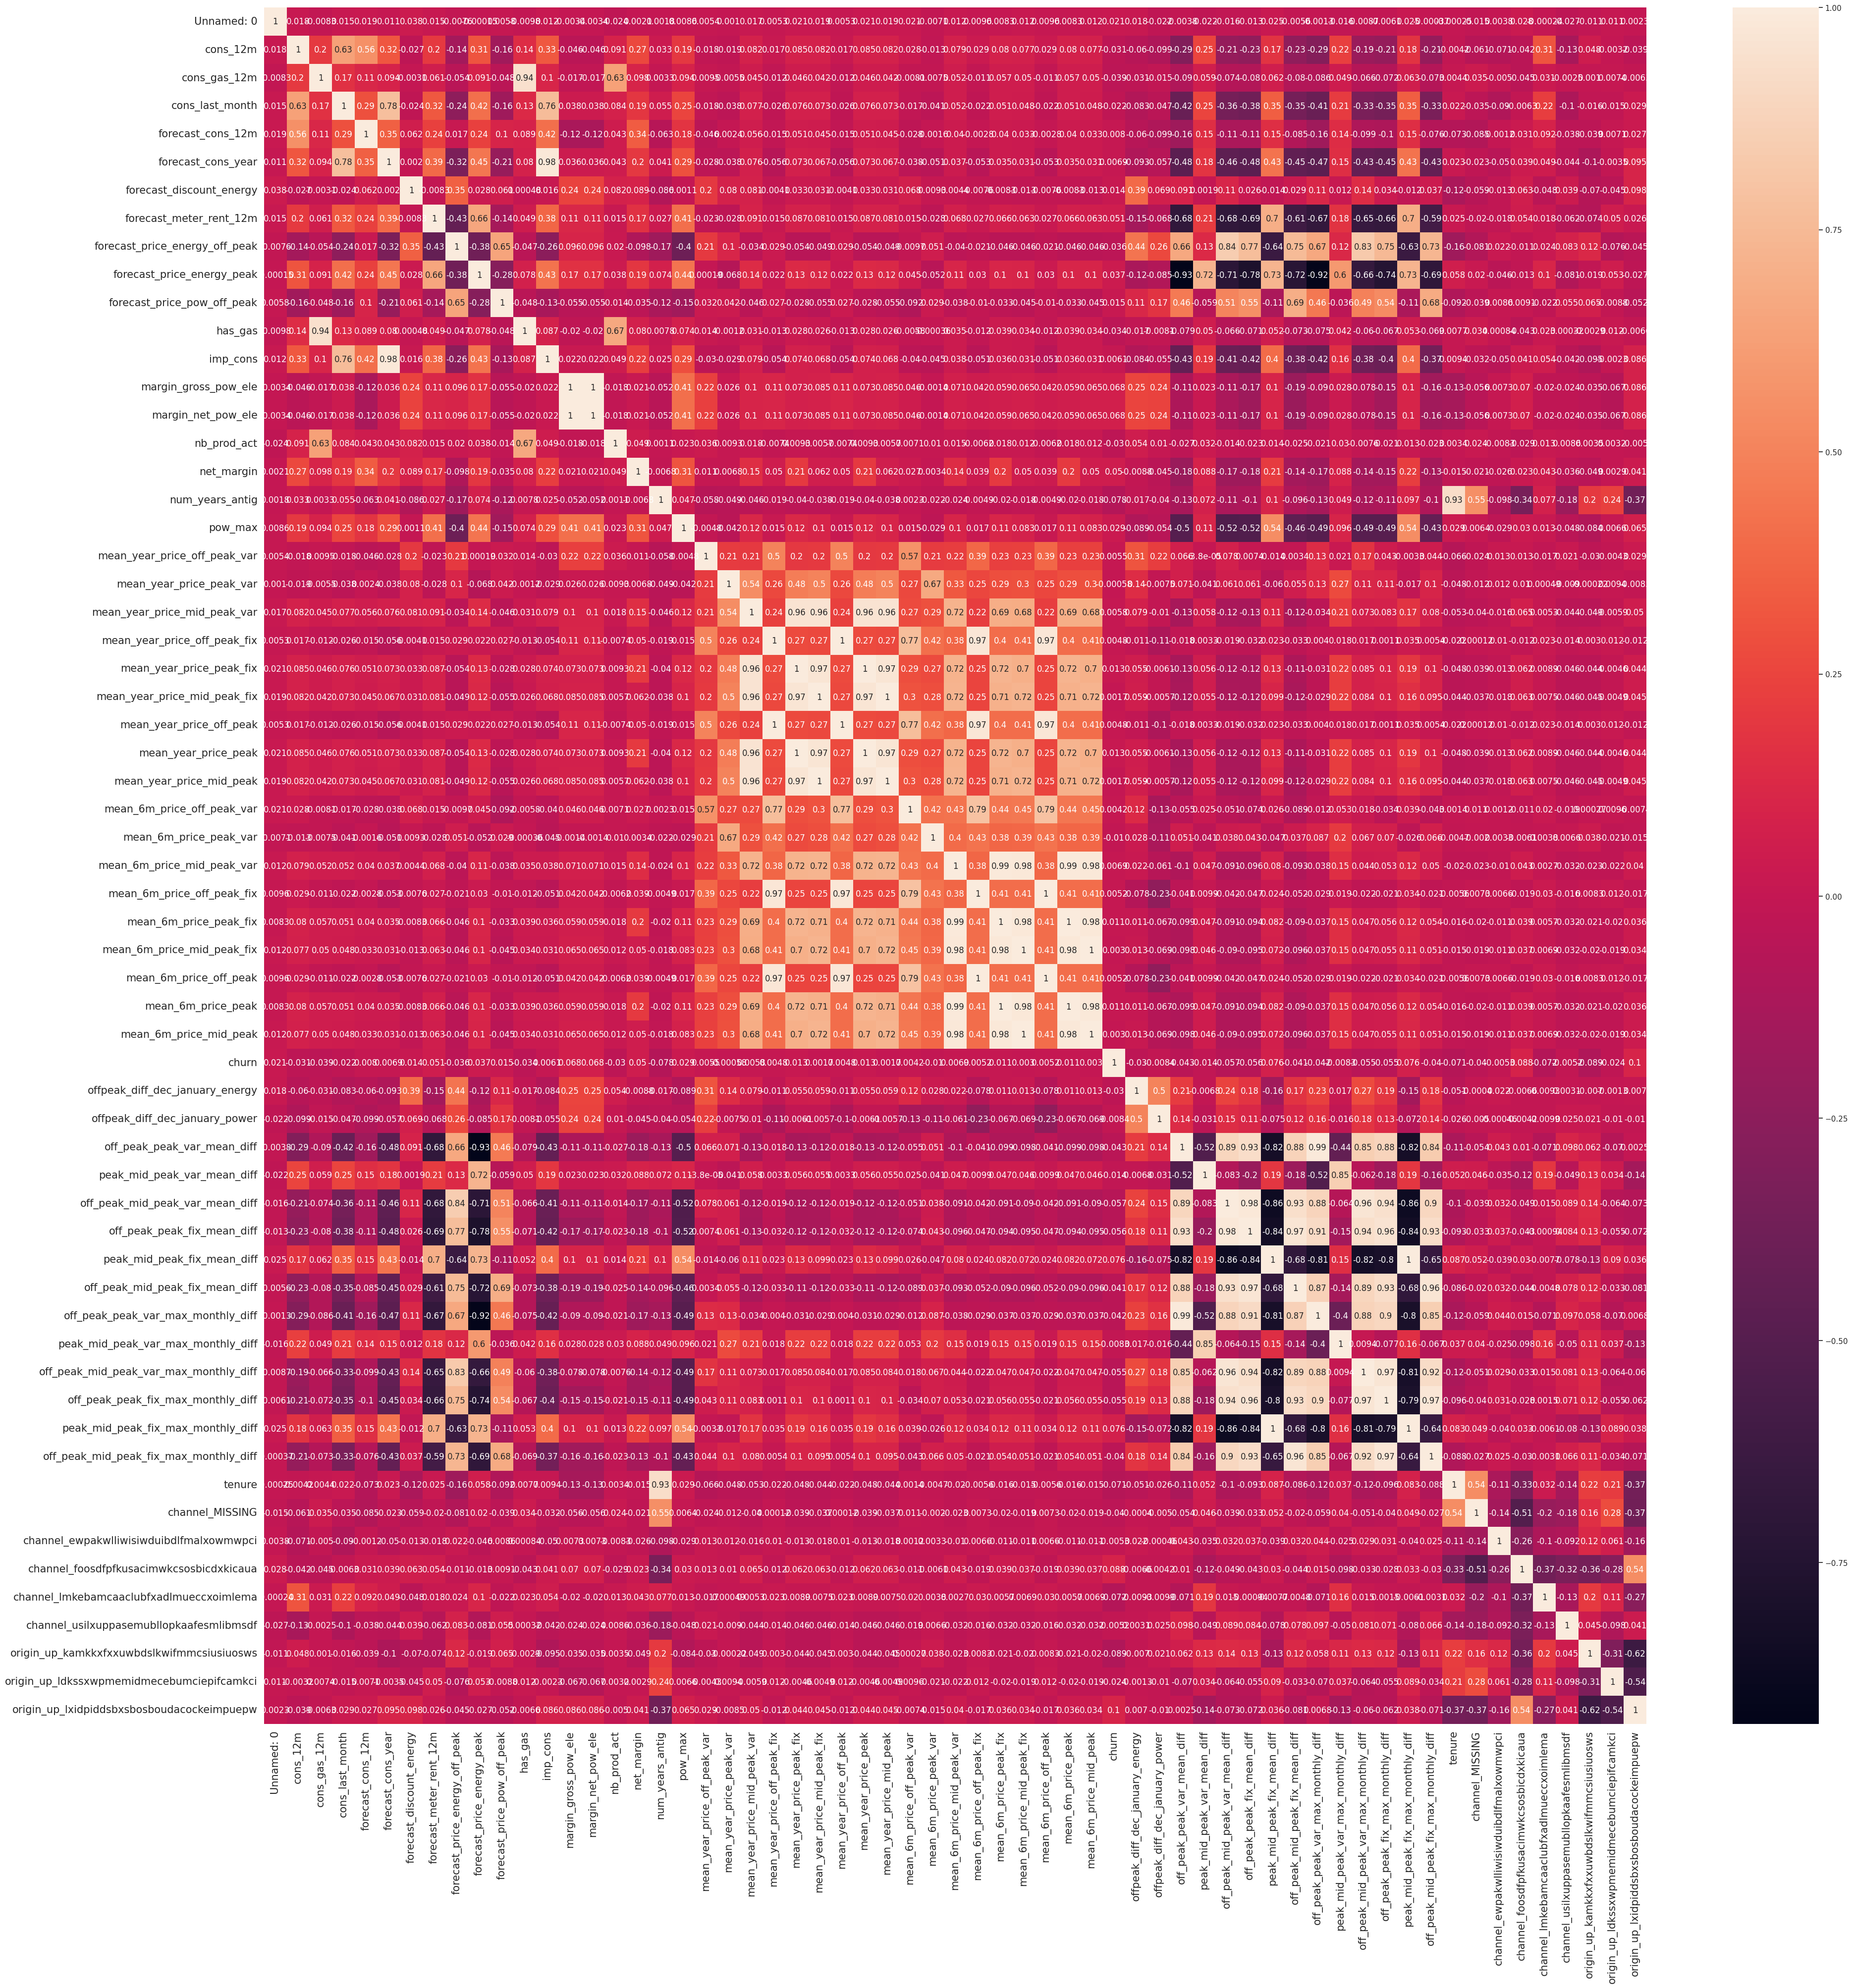

In [56]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Removing two variables which exhibit a high correlation with other independent features.

In [57]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()


Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  764c75f661154dac3a6c254cd082ea7d  2.736397           0.0   
1           1  01495c955be7ec5e7f3203406785aae0  4.470602           0.0   
2           2  d5e512dbc8118a830a7b8c7f61d89992  4.034709           0.0   
3           3  21860c2ff2d5df75503b230ce629c253  3.888011           0.0   
4           4  e4773b60d2e68aac94795782abfc006b  4.672283           0.0   

   cons_last_month  forecast_cons_12m  forecast_discount_energy  \
0         0.000000           1.689841                       0.0   
1         3.100715           2.937382                       0.0   
2         3.493179           3.081196                       0.0   
3         0.000000           2.961469                       0.0   
4         3.499962           3.227447                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                 1.599009                        0.165794   
1                 2.162833                        0.115174   
2                 1.341237                        0.164637   
3                 1.878866                        0.162327   
4                 1.232488                        0.144902   

   forecast_price_energy_peak  ...  off_peak_mid_peak_fix_max_monthly_diff  \
0                    0.087899  ...                                44.44471   
1                    0.098837  ...                                24.43733   
2                    0.087381  ...                                44.44471   
3                    0.084428  ...                                44.44471   
4                    0.000000  ...                                44.44471   

   tenure  channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0       6                0                                         0   
1       6                0                                         0   
2       5                0                                         0   
3       4                0                                         0   
4       4                0                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         1   
2                                         0   
3                                         1   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         1   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           1   
1                                           0   
2                                           1   
3                                           0   
4                                           0   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           1   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           0  
1                                           1  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 60 columns]

# Modelling

In [58]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [60]:
# Make a copy of the data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns = ['id','churn'])
print(X.shape)
print(y.shape)

(4995, 58)
(4995,)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3746, 58)
(3746,)
(1249, 58)
(1249,)


# Model Training

In [62]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [63]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test,predictions).ravel()

In [64]:
y_test.value_counts()

0    1119
1     130
Name: churn, dtype: int64

In [65]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")


True positives: 7
False positives: 2
True negatives: 1117
False negatives: 123

Accuracy: 0.899919935948759
Precision: 0.7777777777777778
Recall: 0.05384615384615385


# Model Understanding

In [66]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

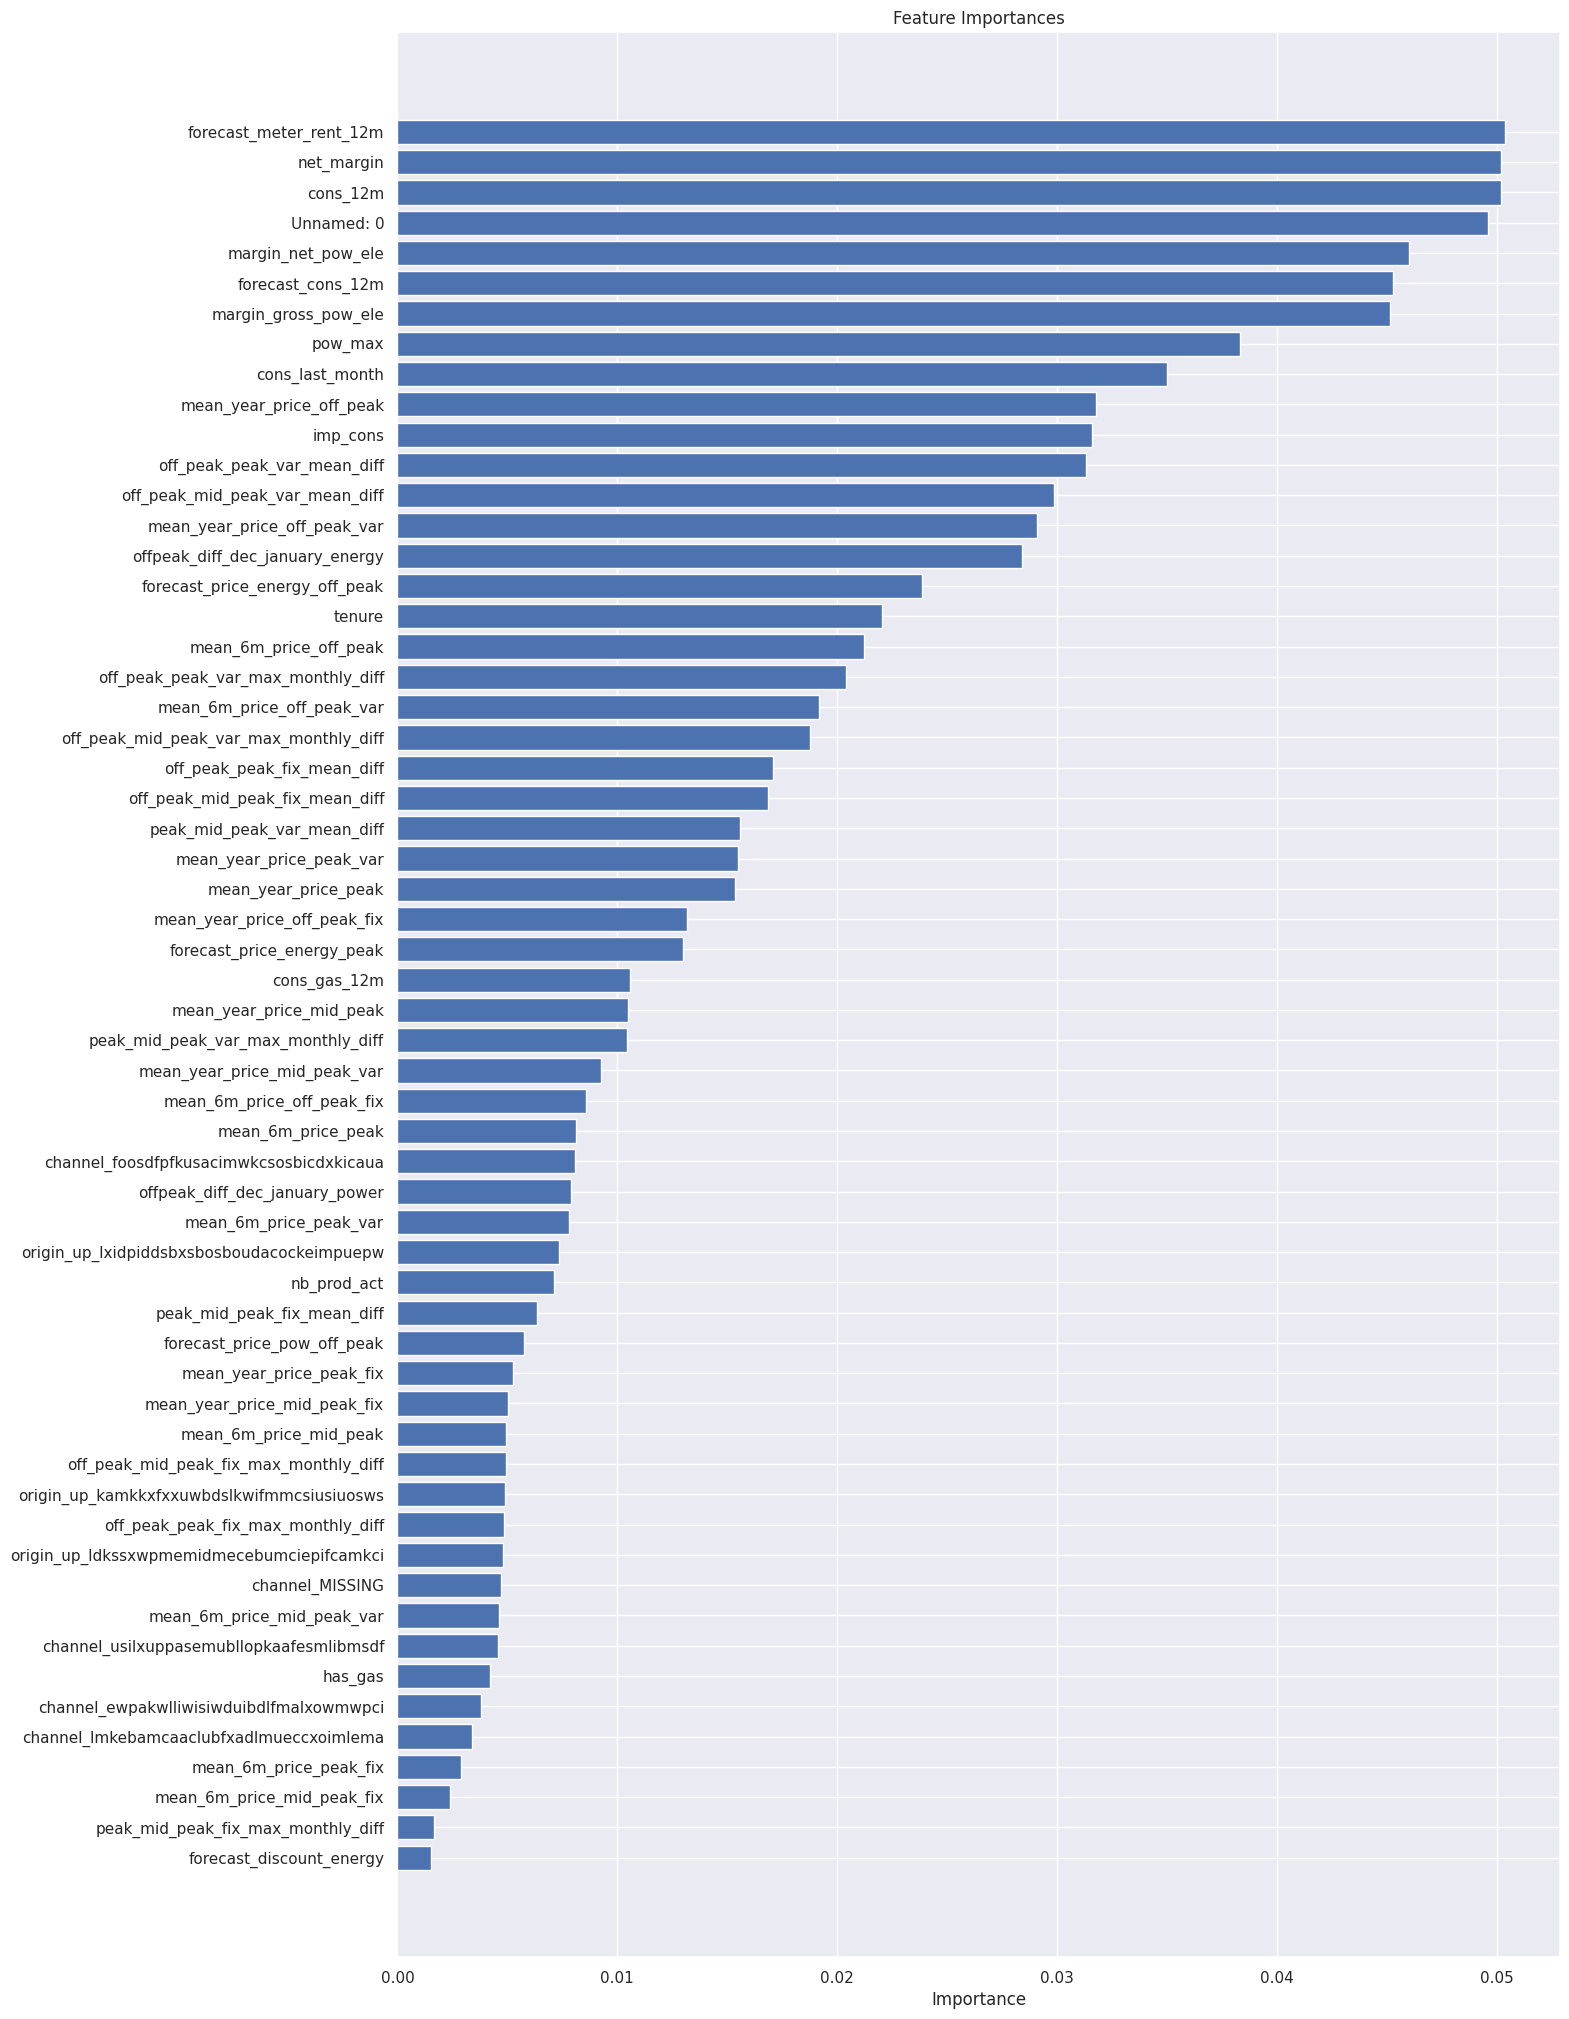

In [67]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()


From this chart, we can observe the following points:

Net margin and consumption over 12 months is a top driver for churn in this model
Margin on power subscription also is an influential driver
Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract
The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
Our price sensitivity features are scattered around but are not the main driver for a customer churning
The last observation is important because this relates back to our original hypothesis:

> Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [68]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]


In [69]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [70]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')